# 猫狗大战

这个项目使用 python3.5 + tensorflow 1.0 + gpu环境

In [37]:
# 导入库
import tensorflow as tf
from imp import reload
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import time
import sys, traceback

import warnings
warnings.filterwarnings('ignore')

import TFHelper
import CatDogDataset

%matplotlib inline

In [38]:
# 全局变量
IMG_SZ = 384
IMG_FT = IMG_SZ * IMG_SZ * 3
LABTXT = ['Cat', 'Dog', 'NODATA']


# 图像可视化
def visualize(imgs, real=None, pred=None):
    size = min(len(imgs), 10)
    fig = plt.figure(figsize=(20, 20))
    if imgs.shape[3] == 1:
        imgs = imgs[:, :, :, -1]
    for i in range(0, size):
        fig.add_subplot(1, size, i + 1) 
        plt.imshow(imgs[i] + .5)  # display it
        predtxt = 'Algorithm: ' + (pred is not None and LABTXT[int(pred[i])] or '---')
        realtxt = 'Real: ' + (real is not None and LABTXT[int(real[i])])
        plt.xlabel(predtxt + '  ' + realtxt)

# 二元精确度
def accuracy(predictions, labels):
    assert(predictions.shape == labels.shape)
    assert(predictions.dtype == labels.dtype)
    pred = np.piecewise(predictions, [predictions < 0.5, predictions >= 0.5], [0, 1])
#     print(pred)
#     print(labels)
#     print(pred == labels, np.sum(pred == labels))
    return 'accuracy', np.sum(pred == labels) / len(labels) * 100

#批次计算精确率
def batch_mean(generator, step, func):
    accs = []
    for i in range(step):
        x,y = next(generator)
        accs.append( func(x, y) )
    print(accs)
    return np.mean(accs)
    
# 图像可视化预测结果
def visualize_predict(clf, generator):   
    x,y = next(generator)
    predict_lab = clf.predict(x)
    pred = np.piecewise(predict_lab, [predict_lab < 0.5, predict_lab >= 0.5], [0, 1])
    visualize(x, y, pred)

train datas:  20001


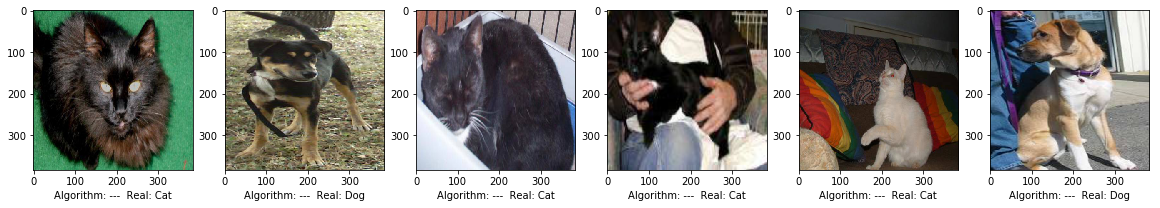

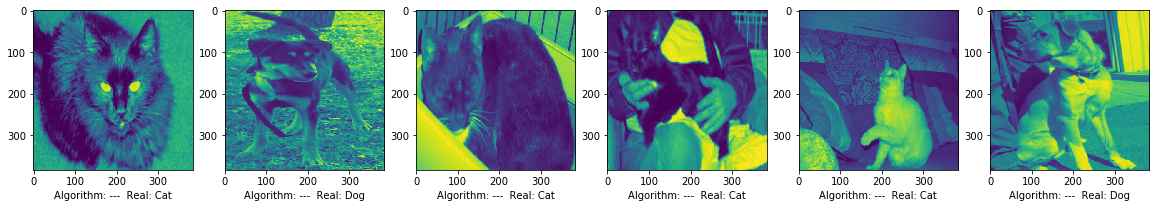

In [43]:
# 数据集准备
CatDogDataset = reload(CatDogDataset)

train, vali, test = CatDogDataset.get_kaggle_reader()
print('train datas: ', train.count)

# 列出数据集里的图 
train_reader = train.get_generator(batch_size=6, image_size=IMG_SZ)
visualize(*next(train_reader))

# 灰度
train_gray_reader = train.get_generator(batch_size=6, image_size=IMG_SZ, gray=True)
visualize(*next(train_gray_reader))

# 检测数据集平衡性

In [44]:
train_labels = train.labels()
print(np.sum(train_labels), len(train_labels), 'dog/all:', np.sum(train_labels) / len(train_labels))

9994 20001 dog/all: 0.499675016249


# 使用线性分类 (可跳过执行）

In [16]:
train_reader = train.get_generator(batch_size=128, image_size=IMG_SZ)
vali_reader = vali.get_generator(batch_size=128, image_size=IMG_SZ)
test_reader = test.get_generator(batch_size=500, image_size=IMG_SZ)
total_steps = int(train.count / 128) + 1

%time vali_dat, vali_lab = next(vali_reader)
vali_dat = vali_dat.reshape(-1, IMG_FT)

from sklearn.linear_model import SGDClassifier
linear_clf = SGDClassifier(penalty='elasticnet', loss='log')

start = time.time()
try:
    for batch in range(0, total_steps):
        dat, lab = next(train_reader)
        dat = dat.reshape(-1, IMG_FT)
        linear_clf.partial_fit(dat, lab, [0,1])
        TFHelper.step_info(batch + 1, total_steps, 
                  {'accuracy': str(round(linear_clf.score(vali_dat, vali_lab)*100, 2)) + '%' })
    print('\nend ', str(time.time() - start), 's')
except Exception as e:
    print('\nerror', e, traceback.format_exc(), str)

reading from beginning:  train/cat.3705.jpg
Wall time: 1.52 s
reading from beginning:  train/dog.11416.jpg
--== Step: 24/157 (15.3%) Score: accuracy 53.12% ==--skip: train/
--== Step: 156/157 (99.4%) Score: accuracy 49.22% ==--reading from beginning:  train/dog.11416.jpg
--== Step: 157/157 (100.0%) Score: accuracy 56.25% ==--
end  407.5491325855255 s


In [40]:
from sklearn.metrics import accuracy_score

print('validation accuracy is:', 
      batch_mean( vali_reader, 10, lambda x, y: accuracy(
                                   linear_clf.predict(x.reshape(-1, IMG_FT)),
                                   y[:, -1].astype(int) )[1] ))

reading from beginning:  train/cat.3705.jpg
[56.25, 60.9375, 53.125, 52.34375, 57.8125, 46.875, 55.46875, 50.78125, 55.46875, 57.03125]
validation accuracy is: 54.609375


# 使用深度学习

In [36]:
# 准备数据
import CatDogDataset
CatDogDataset = reload(CatDogDataset)

train_reader = train.get_generator(batch_size=64, image_size=256)
vali_reader = vali.get_generator(batch_size=16, image_size=256)
test_reader = test.get_generator(batch_size=64, image_size=256)
visualize_test_reader = test.get_generator(batch_size=5, image_size=256)
mini_steps = int(train.count / 128) + 1

%time vali_dat, vali_lab = next(vali_reader)

Wall time: 160 ms


In [31]:
import tensorflow as tf

TFHelper = reload(TFHelper)

def my_loss_func(logits, tf_train_labs):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=tf_train_labs))

# Main Model
def my_model(x_input, drop=None):
    depth1, depth2, depth3, depth4 = 16, 32, 64, 128
    with tf.variable_scope("conv1"):
        relu = TFHelper.conv_relu(x_input, kernel_shape=[3, 3, 3, depth1],  pool=True)
        
    with tf.variable_scope("conv2"):
        relu = TFHelper.conv_relu(relu, kernel_shape=[3, 3, depth1, depth2],  pool=True)
        
    with tf.variable_scope("conv3"):
        relu = TFHelper.conv_relu(relu, kernel_shape=[3, 3, depth2, depth3], pool=True)
        
    with tf.variable_scope("flat"):
        shape = relu.get_shape().as_list()
        csize = shape[1] * shape[2] * shape[3]
        reshape = tf.reshape(relu, [-1, csize])    
        relu = TFHelper.relu(reshape, kernel_shape=[csize, depth4], drop=drop)
        
    with tf.variable_scope("out"):
        weights, biases = TFHelper.var([depth4, 1]) 
        logits = tf.matmul(relu, weights) + biases
        return logits, tf.nn.sigmoid(logits)

clf = TFHelper.Learner(my_model, accuracy, 'catdog',
                     steps=1401, learning_rate=0.001,
                     loss=my_loss_func,
                     optimizer=tf.train.AdamOptimizer
                     )

clf.fit_generator(train_reader, vali_dat, vali_lab)

(64, 256, 256, 3)
Tensor("Placeholder:0", dtype=float32)
Tensor("predict/conv1/Conv2D:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("predict/conv1/MaxPool:0", shape=(?, 128, 128, 16), dtype=float32)
Tensor("predict/conv2/Conv2D:0", shape=(?, 128, 128, 32), dtype=float32)
Tensor("predict/conv2/MaxPool:0", shape=(?, 64, 64, 32), dtype=float32)
Tensor("predict/conv3/Conv2D:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("predict/conv3/MaxPool:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("predict/flat/dropout/mul:0", shape=(?, 128), dtype=float32)
Tensor("predict/out/add:0", shape=(?, 1), dtype=float32)
Tensor("predict/conv1_1/Conv2D:0", shape=(16, 256, 256, 16), dtype=float32)
Tensor("predict/conv1_1/MaxPool:0", shape=(16, 128, 128, 16), dtype=float32)
Tensor("predict/conv2_1/Conv2D:0", shape=(16, 128, 128, 32), dtype=float32)
Tensor("predict/conv2_1/MaxPool:0", shape=(16, 64, 64, 32), dtype=float32)
Tensor("predict/conv3_1/Conv2D:0", shape=(16, 64, 64, 64), dtype=float32)
Tenso

KeyboardInterrupt: 

In [19]:
#评分n*128个vali集上的图像
batch_mean(vali_reader, 30, lambda x, y: accuracy( clf.predict(x), y )[1] )

[50.0, 50.0, 43.75, 46.875, 59.375, 56.25, 62.5, 65.625, 56.25, 50.0, 43.75, 62.5, 56.25, 56.25, 37.5, 46.875, 37.5, 56.25, 59.375, 59.375, 56.25, 71.875, 59.375, 50.0, 56.25, 68.75, 62.5, 59.375, 34.375, 65.625]


54.6875

In [8]:
batch_mean(train_reader, 10, lambda x, y: accuracy( clf.predict(x), y )[1] )

[67.96875, 70.3125, 64.0625, 65.625, 71.09375, 69.53125, 74.21875, 64.84375, 67.96875, 76.5625]


69.21875

(5, 128, 128, 3)
reading from beginning:  test/415.jpg
(5, 128, 128, 3)
(5, 128, 128, 3)


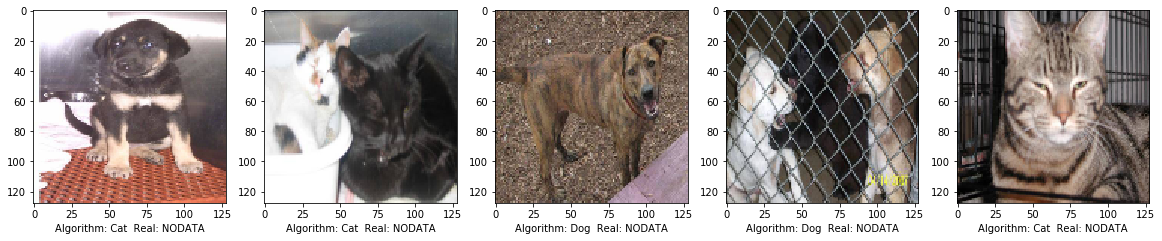

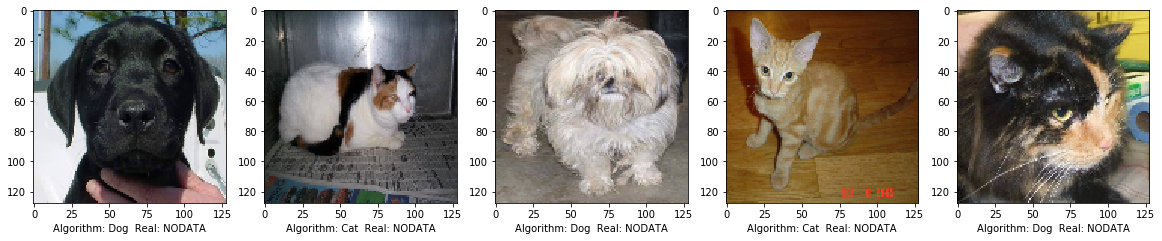

In [37]:
#随机预测2张图显示出来
visualize_predict(clf, visualize_test_reader)
visualize_predict(clf, visualize_test_reader)

In [6]:
import tarfile
a = tarfile.open('./images.tar')
print(a)
print(a.getmembers()[10].name)

Images/n02085620-Chihuahua/n02085620_11948.jpg


In [21]:
PET_CLASS = {
    'chihuahua': 0,

    'japanese_spaniel': 1,
    'japanese_chin': 1,


}
CLASSIFIER = re.compile('|'.join([re.escape(c) for c in PET_CLASS]))
print('|'.join([re.escape(c) for c in PET_CLASS]))

japanese_chin|japanese_spaniel|chihuahua


In [64]:
print(CLASSIFIER.search('xxxjapanese_spanielxxxchihuahua'))

<_sre.SRE_Match object; span=(3, 19), match='japanese_spaniel'>


In [55]:
print(PET_CLASS[CLASSIFIER.search('japanese_spaniel').group()])

1


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D


model = Sequential()
model.add(Convolution2D(8, 3, 3, border_mode='same',
                        input_shape=[128,128,3]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(16, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit_generator(train_reader, 20000, 100, validation_data=vali_reader, nb_val_samples=32)

Epoch 1/100
20000/20000 [==============================] - 71s - loss: 0.6885 - acc: 0.5393 - val_loss: 0.6663 - val_acc: 0.7188